
# Plant Disease Classifier

In [1]:
!pip install split_folders

In [3]:
import splitfolders
import os

os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')
os.makedirs('output/test')
 
loc = "../input/plantvillage-dataset/color"

splitfolders.ratio(loc,output = "output",seed = 42,ratio = (0.80,.1,.1))

Copying files: 54305 files [07:00, 129.09 files/s]


> We are only going to make use of the color images so no need split grayscale and segmented images.

In [2]:
import os

for dirpath,dirname,filename in os.walk("./output"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

There are 3 directories and 0 images in './output'.
There are 38 directories and 0 images in './output\test'.
There are 0 directories and 63 images in './output\test\Apple___Apple_scab'.
There are 0 directories and 63 images in './output\test\Apple___Black_rot'.
There are 0 directories and 28 images in './output\test\Apple___Cedar_apple_rust'.
There are 0 directories and 165 images in './output\test\Apple___healthy'.
There are 0 directories and 151 images in './output\test\Blueberry___healthy'.
There are 0 directories and 86 images in './output\test\Cherry_(including_sour)___healthy'.
There are 0 directories and 106 images in './output\test\Cherry_(including_sour)___Powdery_mildew'.
There are 0 directories and 52 images in './output\test\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'.
There are 0 directories and 120 images in './output\test\Corn_(maize)___Common_rust_'.
There are 0 directories and 117 images in './output\test\Corn_(maize)___healthy'.
There are 0 directories and 99

> After modifying our input data and before the start of modelling its always best to visualize some random images of the dataset

In [4]:
pip install matplotlib tensorflow pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

def plot_random_image(target_dir,target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder),1)
    img = mping.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

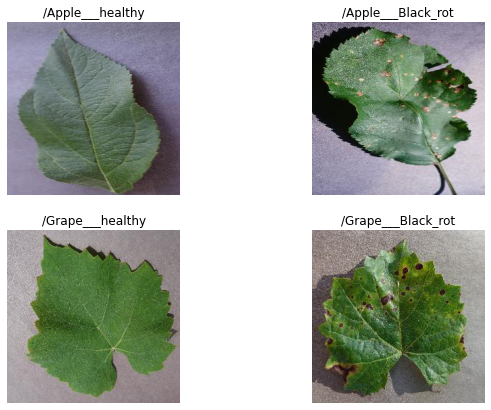

In [7]:
fig = plt.figure(figsize = (10,7))
fig.add_subplot(2,2,1)
img_1 = plot_random_image(target_dir = "./output/train",target_class = "/Apple___healthy")
fig.add_subplot(2,2,2)
img_2 = plot_random_image(target_dir = "./output/train",target_class = "/Apple___Black_rot")
fig.add_subplot(2,2,3)
img_3 = plot_random_image(target_dir = "./output/train",target_class = "/Grape___healthy")
fig.add_subplot(2,2,4)
img_4 = plot_random_image(target_dir = "./output/train",target_class = "/Grape___Black_rot")

# DATA AND CALLBACKS


In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np

In [9]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

2022-10-29 14:41:41.096433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:41:41.097419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:41:41.234440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:41:41.235737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:41:41.236925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

> When we use mixed_precision training the computation speed is increased by 3x times based on the GPU available. Mixed precision enables training using float16 half-precision variables whenever possible.

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "./output/train"
val_dir = "./output/val"
test_dir  = "./output/test"


train_data = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = True)


val_data = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = False)


test_data = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = False)

Found 43429 files belonging to 38 classes.


2022-10-29 14:42:14.432692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 14:42:14.685185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:42:14.686004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 14:42:14.686857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Found 5417 files belonging to 38 classes.
Found 5459 files belonging to 38 classes.


In [11]:
print(train_data)
print(test_data)
print(val_data)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>


In [12]:
class_names = train_data.class_names
print(len(class_names))
print(class_names)

38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

In [13]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5,min_delta = 0.0001,restore_best_weights = True,verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",paitence = 4,factor = 0.5,patience = 4,min_lr = 1e-7,verbose = 1)

In [15]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Feature Extractor DenseNet169

In [16]:
base_model = tf.keras.applications.DenseNet169(include_top = False)
base_model.trainable = False

51888128/51877672 [==============================] - 0s 0us/step


In [17]:
for layer_num,layer in enumerate(base_model.layers):
  print(layer_num,layer.name,layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug = tf.keras.Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.Rescaling(1/255.)
],name = "data_augmentation_layer")

> Data augmentation is used here to prevent overfitting, we can experiment without data augmentation and check whether the model overfits or not,but since we are using a transfer learning Architecture such as DenseNet,its best to include data augmentation since the probability of our model overfitting is very high.

In [19]:
inputs = layers.Input(shape = (224,224,3),name = "Input_layer")
x = data_aug(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)
x = layers.Dense(32,activation = "relu",kernel_initializer = tf.keras.initializers.HeNormal(),name = "Dense_layer_1")(x)
x = layers.Dense(38,name = "Dense_layer_2")(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model_1 = tf.keras.Model(inputs,outputs)

In [20]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
Global_average_pooling_layer (None, 1664)              0         
_________________________________________________________________
Dense_layer_1 (Dense)        (None, 32)                53280     
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 38)                1254      
_________________________________________________________________
activation (Activation)      (None, 38)                0     

In [21]:
for layer_num,layer in enumerate(model_1.layers):
  print(layer_num,layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

0 Input_layer True float32 <Policy "float32">
1 data_augmentation_layer True float32 <Policy "mixed_float16">
2 densenet169 False float32 <Policy "mixed_float16">
3 Global_average_pooling_layer True float32 <Policy "mixed_float16">
4 Dense_layer_1 True float32 <Policy "mixed_float16">
5 Dense_layer_2 True float32 <Policy "mixed_float16">
6 activation True float32 <Policy "float32">


In [22]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [23]:
history_1 = model_1.fit(train_data,epochs = 15,steps_per_epoch=len(train_data),
                        validation_data = val_data,validation_steps = int(0.25*len(val_data)),
                        callbacks = [early_stop,reduce_lr])

Epoch 1/15


2022-10-29 14:44:04.685967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-29 14:44:07.725314: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 342/1358 [======>.......................] - ETA: 1:54 - loss: 1.6369 - accuracy: 0.5951

Cleanup called...


1358/1358 [==============================] - 161s 106ms/step - loss: 0.7719 - accuracy: 0.7988 - val_loss: 0.2483 - val_accuracy: 0.9271
Epoch 2/15
 342/1358 [======>.......................] - ETA: 1:34 - loss: 0.3199 - accuracy: 0.9050

Cleanup called...


1358/1358 [==============================] - 127s 94ms/step - loss: 0.2799 - accuracy: 0.9137 - val_loss: 0.1937 - val_accuracy: 0.9375
Epoch 3/15
 342/1358 [======>.......................] - ETA: 1:29 - loss: 0.2253 - accuracy: 0.9304

Cleanup called...


1358/1358 [==============================] - 122s 90ms/step - loss: 0.2136 - accuracy: 0.9321 - val_loss: 0.1211 - val_accuracy: 0.9598
Epoch 4/15
 342/1358 [======>.......................] - ETA: 1:29 - loss: 0.1994 - accuracy: 0.9349

Cleanup called...


1358/1358 [==============================] - 120s 88ms/step - loss: 0.1872 - accuracy: 0.9395 - val_loss: 0.1029 - val_accuracy: 0.9680
Epoch 5/15
 343/1358 [======>.......................] - ETA: 1:26 - loss: 0.1775 - accuracy: 0.9421

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.1686 - accuracy: 0.9446 - val_loss: 0.0910 - val_accuracy: 0.9680
Epoch 6/15
 343/1358 [======>.......................] - ETA: 1:23 - loss: 0.1632 - accuracy: 0.9465

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.1537 - accuracy: 0.9488 - val_loss: 0.1250 - val_accuracy: 0.9576
Epoch 7/15
 342/1358 [======>.......................] - ETA: 1:24 - loss: 0.1543 - accuracy: 0.9481

Cleanup called...


1358/1358 [==============================] - 115s 85ms/step - loss: 0.1493 - accuracy: 0.9499 - val_loss: 0.0997 - val_accuracy: 0.9665
Epoch 8/15
 343/1358 [======>.......................] - ETA: 1:23 - loss: 0.1427 - accuracy: 0.9540

Cleanup called...


1358/1358 [==============================] - 114s 84ms/step - loss: 0.1445 - accuracy: 0.9526 - val_loss: 0.1240 - val_accuracy: 0.9606
Epoch 9/15
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.1322 - accuracy: 0.9564

Cleanup called...


1358/1358 [==============================] - 113s 83ms/step - loss: 0.1348 - accuracy: 0.9556 - val_loss: 0.0724 - val_accuracy: 0.9747
Epoch 10/15
 342/1358 [======>.......................] - ETA: 1:19 - loss: 0.1418 - accuracy: 0.9512

Cleanup called...


1358/1358 [==============================] - 112s 82ms/step - loss: 0.1302 - accuracy: 0.9552 - val_loss: 0.0841 - val_accuracy: 0.9702
Epoch 11/15
 342/1358 [======>.......................] - ETA: 1:22 - loss: 0.1382 - accuracy: 0.9529

Cleanup called...


1358/1358 [==============================] - 111s 82ms/step - loss: 0.1333 - accuracy: 0.9551 - val_loss: 0.1089 - val_accuracy: 0.9643
Epoch 12/15
 342/1358 [======>.......................] - ETA: 1:21 - loss: 0.1267 - accuracy: 0.9558

Cleanup called...


1358/1358 [==============================] - 113s 83ms/step - loss: 0.1222 - accuracy: 0.9582 - val_loss: 0.0662 - val_accuracy: 0.9777
Epoch 13/15
 341/1358 [======>.......................] - ETA: 1:22 - loss: 0.1261 - accuracy: 0.9564

Cleanup called...


1358/1358 [==============================] - 111s 82ms/step - loss: 0.1242 - accuracy: 0.9575 - val_loss: 0.0872 - val_accuracy: 0.9680
Epoch 14/15
 342/1358 [======>.......................] - ETA: 1:20 - loss: 0.1232 - accuracy: 0.9600

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.1236 - accuracy: 0.9585 - val_loss: 0.0949 - val_accuracy: 0.9688
Epoch 15/15
 342/1358 [======>.......................] - ETA: 1:19 - loss: 0.1167 - accuracy: 0.9588

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.1162 - accuracy: 0.9596 - val_loss: 0.0613 - val_accuracy: 0.9784


In [24]:
print("Validation Accuracy = ",model_1.evaluate(val_data))
print("Testing Accuracy is = ",model_1.evaluate(test_data))

170/170 [==============================] - 12s 71ms/step - loss: 0.1410 - accuracy: 0.9544
Validation Accuracy =  [0.14104923605918884, 0.9544028043746948]
171/171 [==============================] - 13s 73ms/step - loss: 0.1434 - accuracy: 0.9516
Testing Accuracy is =  [0.1433558464050293, 0.9516394734382629]


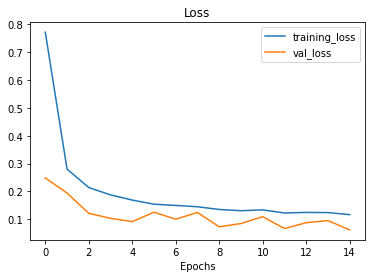

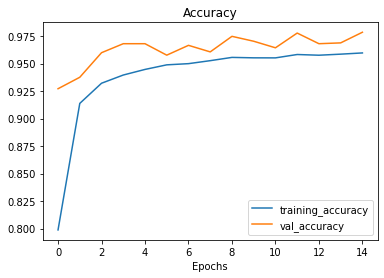

In [25]:
plot_loss_curves(history_1)

> * Training Accuracy - 95.96%
> * Testing Accuracy  - 95.16%
> * Validation Accuracy - 95.44%

# Fine Tuned DenseNet169

In [26]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

> Now in order to improve our model's performance we unfreeze the top 30 layers closer to the output layer and let them train on our data instead of using pre-trained weights.

In [27]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [28]:
for layer_num,layer in enumerate(model_1.layers):
  print(layer_num,layer.name,layer.trainable)

0 Input_layer True
1 data_augmentation_layer True
2 densenet169 True
3 Global_average_pooling_layer True
4 Dense_layer_1 True
5 Dense_layer_2 True
6 activation True


In [29]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(1e-4),
                metrics = ["accuracy"])

In [30]:
history_2 = model_1.fit(train_data,epochs = 30,initial_epoch = history_1.epoch[-1],steps_per_epoch=len(train_data),
                        validation_data = val_data,validation_steps = int(0.25*len(val_data)),
                        callbacks = [early_stop,reduce_lr])

Epoch 15/30
 342/1358 [======>.......................] - ETA: 1:27 - loss: 0.2832 - accuracy: 0.9235

Cleanup called...


1358/1358 [==============================] - 131s 89ms/step - loss: 0.1810 - accuracy: 0.9468 - val_loss: 0.0964 - val_accuracy: 0.9688
Epoch 16/30
 341/1358 [======>.......................] - ETA: 1:24 - loss: 0.1274 - accuracy: 0.9589

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.1227 - accuracy: 0.9615 - val_loss: 0.1195 - val_accuracy: 0.9680
Epoch 17/30
 342/1358 [======>.......................] - ETA: 1:29 - loss: 0.1084 - accuracy: 0.9668

Cleanup called...


1358/1358 [==============================] - 122s 90ms/step - loss: 0.1022 - accuracy: 0.9675 - val_loss: 0.0841 - val_accuracy: 0.9747
Epoch 18/30
 343/1358 [======>.......................] - ETA: 1:25 - loss: 0.0892 - accuracy: 0.9713

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.0863 - accuracy: 0.9711 - val_loss: 0.1136 - val_accuracy: 0.9680
Epoch 19/30
 342/1358 [======>.......................] - ETA: 1:25 - loss: 0.0798 - accuracy: 0.9756

Cleanup called...


1358/1358 [==============================] - 116s 85ms/step - loss: 0.0797 - accuracy: 0.9752 - val_loss: 0.1118 - val_accuracy: 0.9725
Epoch 20/30
 343/1358 [======>.......................] - ETA: 1:25 - loss: 0.0723 - accuracy: 0.9779

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.0703 - accuracy: 0.9776 - val_loss: 0.0706 - val_accuracy: 0.9769
Epoch 21/30
 342/1358 [======>.......................] - ETA: 1:25 - loss: 0.0636 - accuracy: 0.9794

Cleanup called...


1358/1358 [==============================] - 116s 85ms/step - loss: 0.0609 - accuracy: 0.9793 - val_loss: 0.0919 - val_accuracy: 0.9732
Epoch 22/30
 342/1358 [======>.......................] - ETA: 1:22 - loss: 0.0522 - accuracy: 0.9830

Cleanup called...


1358/1358 [==============================] - 115s 85ms/step - loss: 0.0536 - accuracy: 0.9822 - val_loss: 0.0776 - val_accuracy: 0.9762
Epoch 23/30
 343/1358 [======>.......................] - ETA: 1:25 - loss: 0.0611 - accuracy: 0.9807

Cleanup called...


1358/1358 [==============================] - 116s 85ms/step - loss: 0.0537 - accuracy: 0.9823 - val_loss: 0.0781 - val_accuracy: 0.9762
Epoch 24/30
 343/1358 [======>.......................] - ETA: 1:23 - loss: 0.0504 - accuracy: 0.9841

Cleanup called...


1358/1358 [==============================] - 116s 85ms/step - loss: 0.0472 - accuracy: 0.9848 - val_loss: 0.0610 - val_accuracy: 0.9769
Epoch 25/30
 342/1358 [======>.......................] - ETA: 1:29 - loss: 0.0427 - accuracy: 0.9866

Cleanup called...


1358/1358 [==============================] - 123s 91ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.0623 - val_accuracy: 0.9792
Epoch 26/30
 342/1358 [======>.......................] - ETA: 1:24 - loss: 0.0400 - accuracy: 0.9861

Cleanup called...


1358/1358 [==============================] - 115s 85ms/step - loss: 0.0386 - accuracy: 0.9870 - val_loss: 0.0519 - val_accuracy: 0.9821
Epoch 27/30
 342/1358 [======>.......................] - ETA: 1:26 - loss: 0.0408 - accuracy: 0.9860

Cleanup called...


1358/1358 [==============================] - 118s 87ms/step - loss: 0.0385 - accuracy: 0.9871 - val_loss: 0.0536 - val_accuracy: 0.9851
Epoch 28/30
 342/1358 [======>.......................] - ETA: 1:27 - loss: 0.0374 - accuracy: 0.9892

Cleanup called...


1358/1358 [==============================] - 118s 87ms/step - loss: 0.0353 - accuracy: 0.9885 - val_loss: 0.0498 - val_accuracy: 0.9859
Epoch 29/30
 343/1358 [======>.......................] - ETA: 1:27 - loss: 0.0353 - accuracy: 0.9884

Cleanup called...


1358/1358 [==============================] - 119s 88ms/step - loss: 0.0369 - accuracy: 0.9881 - val_loss: 0.0402 - val_accuracy: 0.9866
Epoch 30/30
 343/1358 [======>.......................] - ETA: 1:25 - loss: 0.0327 - accuracy: 0.9892

Cleanup called...


1358/1358 [==============================] - 118s 87ms/step - loss: 0.0305 - accuracy: 0.9896 - val_loss: 0.0640 - val_accuracy: 0.9777


In [31]:
print("Validation Accuracy = ",model_1.evaluate(val_data))
print("Testing Accuracy is = ",model_1.evaluate(test_data))

170/170 [==============================] - 12s 71ms/step - loss: 0.0735 - accuracy: 0.9780
Validation Accuracy =  [0.07353338599205017, 0.978032112121582]
171/171 [==============================] - 13s 74ms/step - loss: 0.0791 - accuracy: 0.9800
Testing Accuracy is =  [0.07907363027334213, 0.9800329804420471]


In [32]:
def compare_historys(original_history, new_history, initial_epochs):
    
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

15
31
[0.7987520098686218, 0.9137442708015442, 0.9320730566978455, 0.9395334720611572, 0.944622278213501, 0.9487899541854858, 0.9498721957206726, 0.9525892734527588, 0.9555596709251404, 0.9551681876182556, 0.955122172832489, 0.9581845998764038, 0.9575399160385132, 0.9585070013999939, 0.959612250328064, 0.9468327760696411, 0.9615004062652588, 0.9675101637840271, 0.971102237701416, 0.9751778841018677, 0.9776416420936584, 0.9793225526809692, 0.9821547865867615, 0.9822929501533508, 0.9847567081451416, 0.9863916039466858, 0.9870362877845764, 0.9871053695678711, 0.9885330200195312, 0.9881415367126465, 0.9895921945571899]


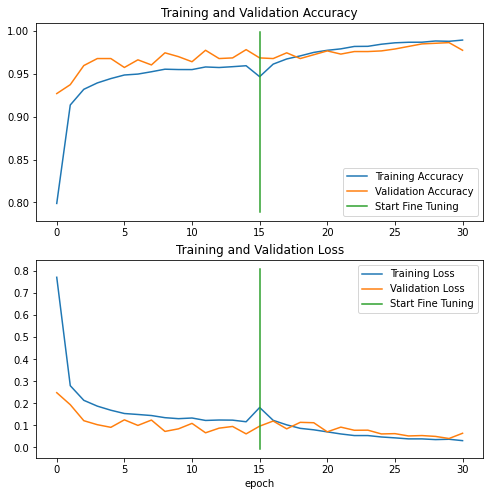

In [33]:
compare_historys(history_1,history_2,initial_epochs = 16)

> *  Training accuracy - 98.96%
> *  Testing Accuracy - 98%
> *  Validation Accuracy - 97.8%

# Model Evaluation

In [34]:
pred_probs = model_1.predict(test_data)
pred_probs[0]

array([9.9996245e-01, 2.3580726e-10, 1.4905703e-08, 3.5842877e-05,
       1.1263320e-14, 4.3021225e-12, 1.0054009e-16, 2.5929633e-15,
       2.4638412e-17, 4.9131788e-12, 3.2778129e-15, 4.2596785e-13,
       3.8160717e-17, 8.9475622e-13, 2.5489233e-12, 7.3137886e-16,
       5.1012128e-09, 6.8418391e-18, 1.6551325e-13, 1.7298880e-18,
       7.1186370e-14, 1.4721055e-13, 8.6488946e-18, 1.5395132e-14,
       4.3856649e-14, 1.6495981e-06, 2.7876981e-14, 2.7626685e-09,
       3.4912975e-11, 2.0641811e-12, 9.2177027e-10, 2.1973092e-12,
       1.5015884e-11, 7.3137886e-16, 2.4082038e-13, 1.2763013e-14,
       3.3920585e-21, 5.3960712e-12], dtype=float32)

In [35]:
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[0]

0

In [36]:
y_labels = []
for img,label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
print(len(y_labels))
print(len(pred_classes))

5459
5459


In [38]:
from sklearn.metrics import classification_report
print("Classification Report\n",classification_report(y_labels,pred_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.95      1.00      0.98        63
           2       1.00      1.00      1.00        28
           3       0.98      0.98      0.98       165
           4       0.99      1.00      1.00       151
           5       1.00      0.95      0.98       106
           6       0.97      0.99      0.98        86
           7       0.97      0.69      0.81        52
           8       1.00      1.00      1.00       120
           9       0.86      0.99      0.92        99
          10       1.00      0.99      1.00       117
          11       1.00      0.98      0.99       118
          12       0.98      1.00      0.99       139
          13       1.00      1.00      1.00       109
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00       552
          16       0.99      1.00      0.99       231
    

In [39]:
classification_dict = classification_report(y_labels,pred_classes,output_dict = True)
classification_dict

{'0': {'precision': 0.9841269841269841,
  'recall': 0.9841269841269841,
  'f1-score': 0.9841269841269841,
  'support': 63},
 '1': {'precision': 0.9545454545454546,
  'recall': 1.0,
  'f1-score': 0.9767441860465117,
  'support': 63},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28},
 '3': {'precision': 0.9817073170731707,
  'recall': 0.9757575757575757,
  'f1-score': 0.9787234042553191,
  'support': 165},
 '4': {'precision': 0.993421052631579,
  'recall': 1.0,
  'f1-score': 0.9966996699669968,
  'support': 151},
 '5': {'precision': 1.0,
  'recall': 0.9528301886792453,
  'f1-score': 0.9758454106280194,
  'support': 106},
 '6': {'precision': 0.9659090909090909,
  'recall': 0.9883720930232558,
  'f1-score': 0.9770114942528736,
  'support': 86},
 '7': {'precision': 0.972972972972973,
  'recall': 0.6923076923076923,
  'f1-score': 0.8089887640449438,
  'support': 52},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 120},
 '9': {'precision': 0.8596491

In [40]:
classification_f1_scores = {}

for k,v in classification_dict.items():
  if k == "accuracy":
    break
  else:
    classification_f1_scores[class_names[int(k)]] = v["f1-score"]
classification_f1_scores

{'Apple___Apple_scab': 0.9841269841269841,
 'Apple___Black_rot': 0.9767441860465117,
 'Apple___Cedar_apple_rust': 1.0,
 'Apple___healthy': 0.9787234042553191,
 'Blueberry___healthy': 0.9966996699669968,
 'Cherry_(including_sour)___Powdery_mildew': 0.9758454106280194,
 'Cherry_(including_sour)___healthy': 0.9770114942528736,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.8089887640449438,
 'Corn_(maize)___Common_rust_': 1.0,
 'Corn_(maize)___Northern_Leaf_Blight': 0.9201877934272301,
 'Corn_(maize)___healthy': 0.9957081545064378,
 'Grape___Black_rot': 0.9914529914529915,
 'Grape___Esca_(Black_Measles)': 0.9893238434163701,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1.0,
 'Grape___healthy': 1.0,
 'Orange___Haunglongbing_(Citrus_greening)': 0.9972801450589303,
 'Peach___Bacterial_spot': 0.9935483870967742,
 'Peach___healthy': 1.0,
 'Pepper,_bell___Bacterial_spot': 0.9900990099009901,
 'Pepper,_bell___healthy': 0.9932885906040269,
 'Potato___Early_blight': 0.9803921568627451,

In [41]:
f1_scores = pd.DataFrame({"class_name":list(classification_f1_scores.keys()),
                          "F1_Score": list(classification_f1_scores.values())})

f1_scores.sort_values("F1_Score",ascending = False)

,class_name,F1_Score
8,Corn_(maize)___Common_rust_,1.000000
2,Apple___Cedar_apple_rust,1.000000
14,Grape___healthy,1.000000
17,Peach___healthy,1.000000
13,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),1.000000
15,Orange___Haunglongbing_(Citrus_greening),0.997280
24,Soybean___healthy,0.997056
4,Blueberry___healthy,0.996700
10,Corn_(maize)___healthy,0.995708
25,Squash___Powdery_mildew,0.994595


In [42]:
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
  n_classes = cm.shape[0]

 
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

 
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

 
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  
  threshold = (cm.max() + cm.min()) / 2.

  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  
  if savefig:
    fig.savefig("confusion_matrix.png")

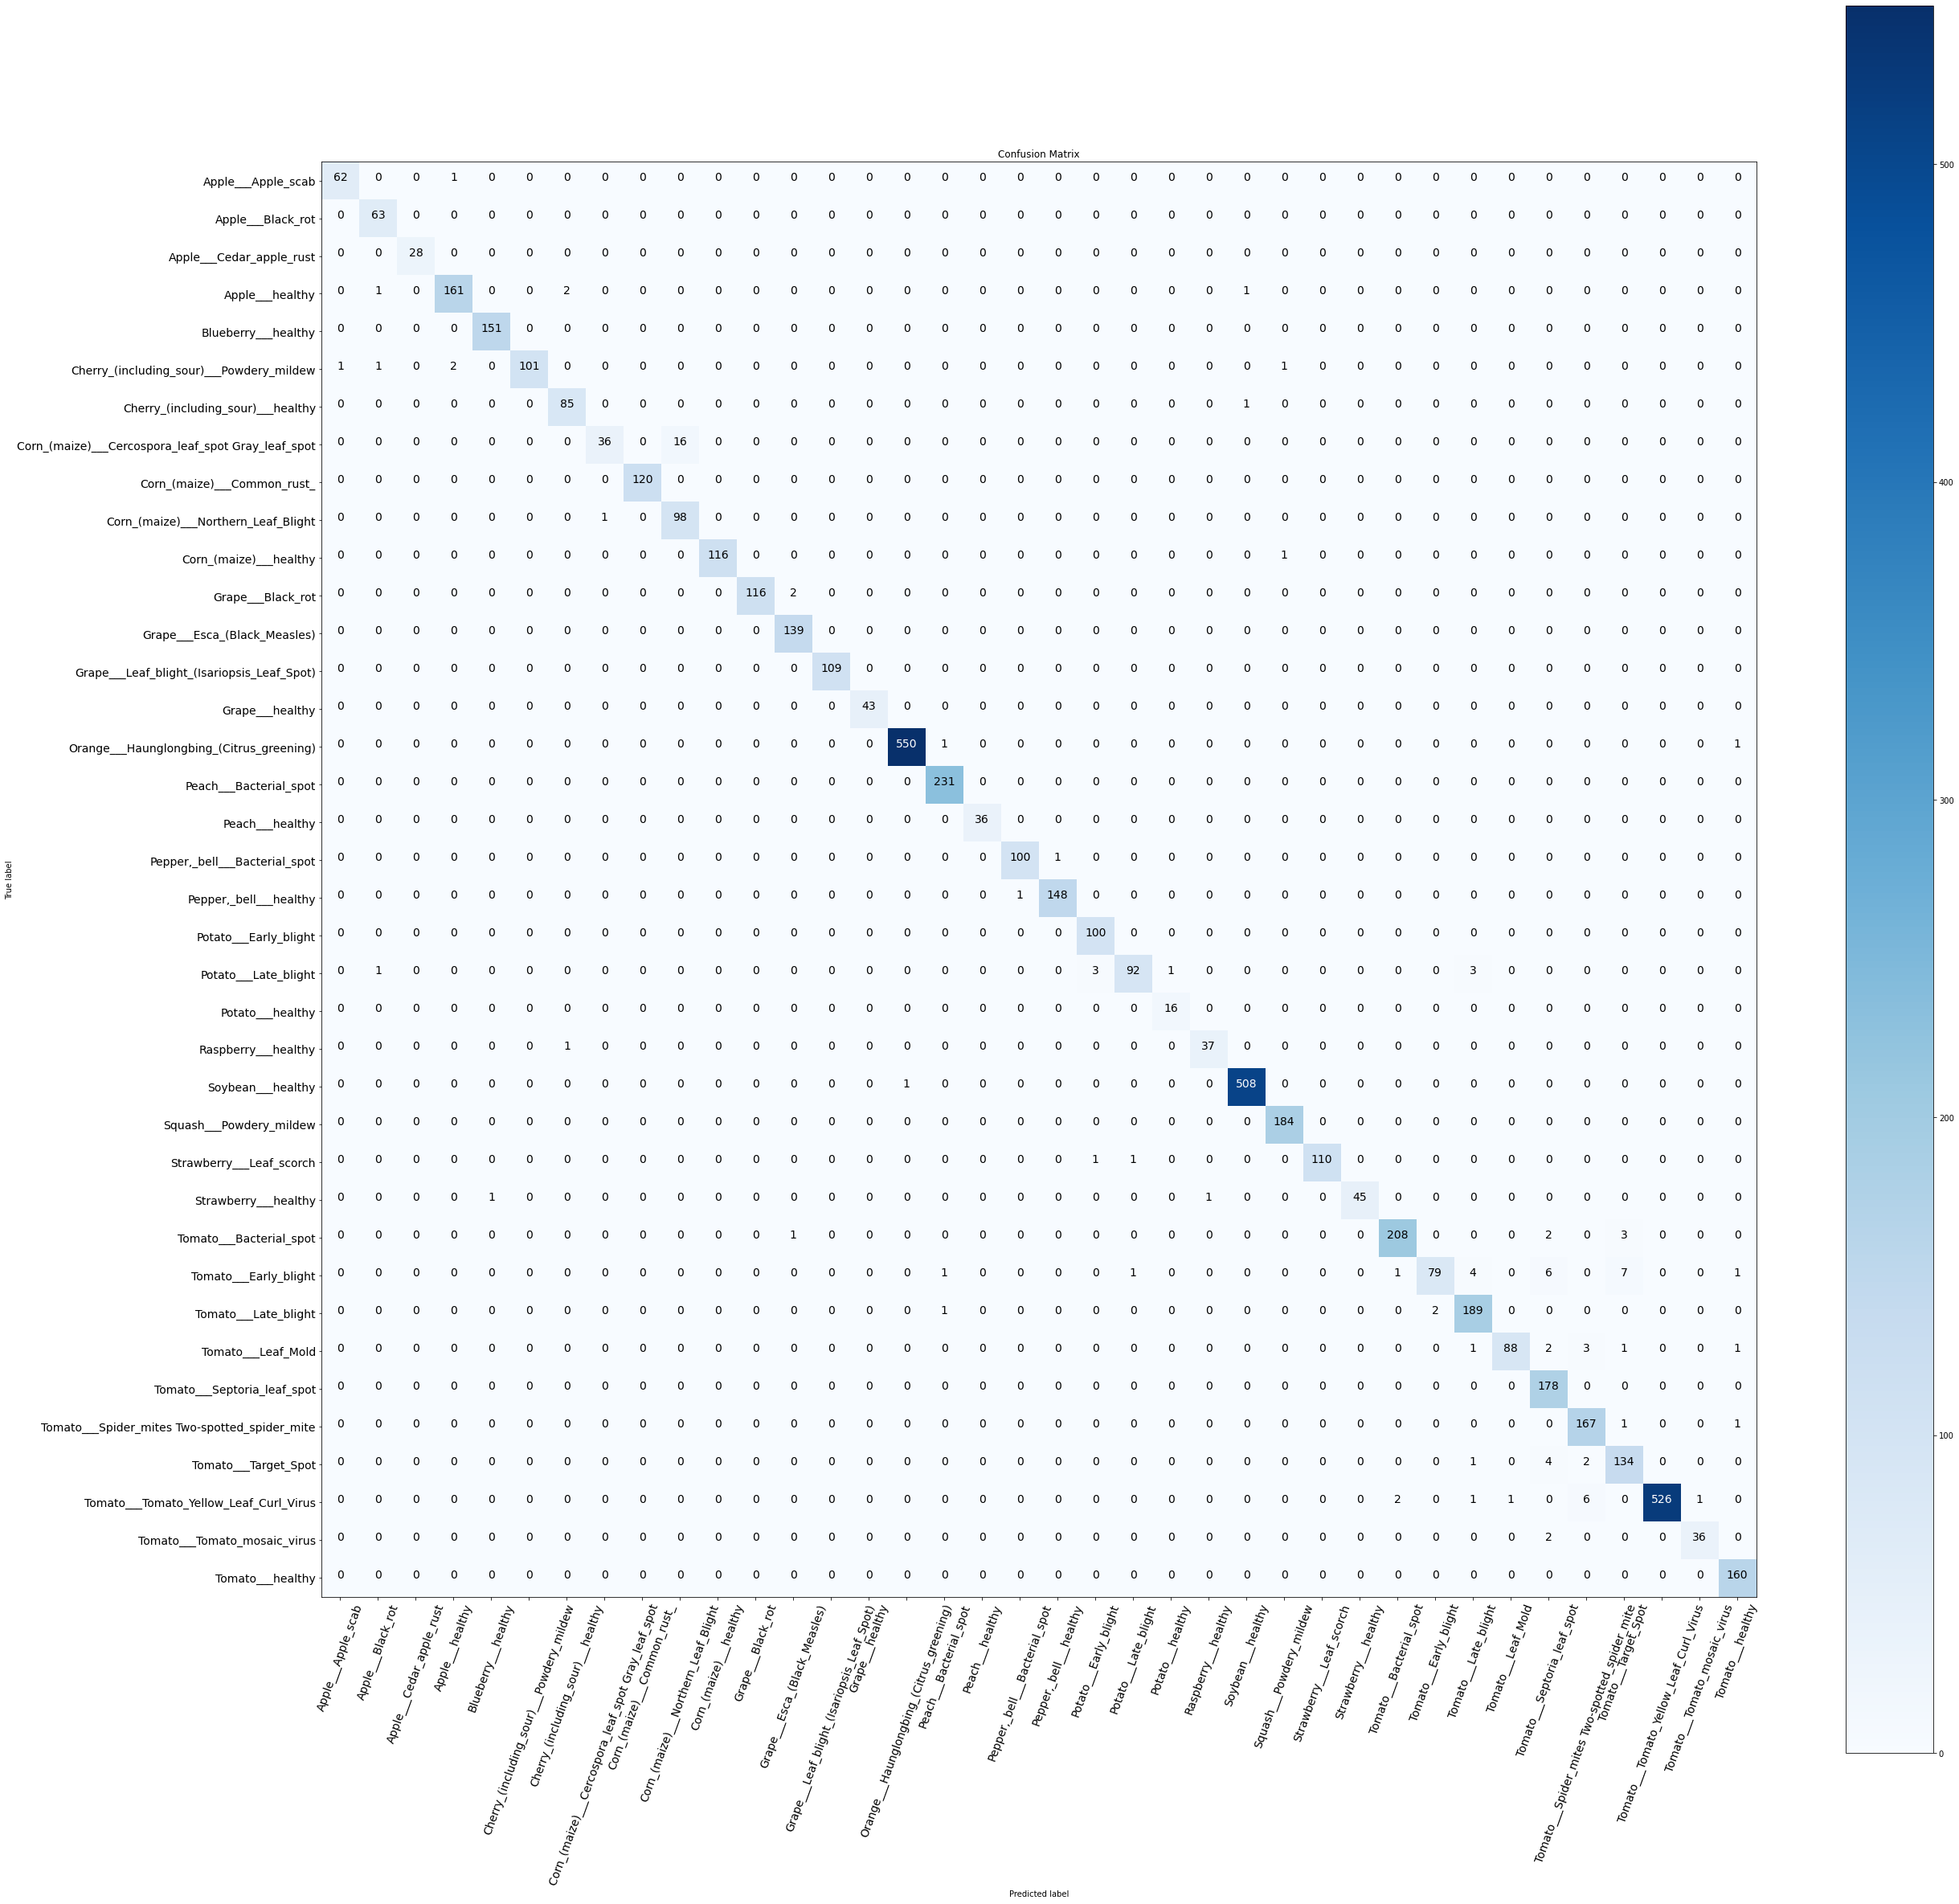

In [45]:
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (40,40),text_size = 14)

>  From the confusion matrix(when zoomed) it clear that our model is getting confused between Tomato Early Blight and Tomato Spider mites, Tomato Early Blight and Tomato Target Spot.